### 데이터 읽어오기

In [1]:
import glob
import os, re
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' 
txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

### 데이터 정제

In [2]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(f"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == "]": continue
        
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
corpus[:5]

['<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>']

### 데이터셋 토큰화

In [3]:
import tensorflow as tf
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=12000,
                                                     filters=' ',
                                                     oov_token='<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                          padding='post',
                                                          maxlen=20)
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   7 156 ...   0   0   0]
 [  2  17   7 ...   0   0   0]
 [  2   6  98 ...   0   0   0]
 ...
 [  2 310   1 ...   0   0   0]
 [  2 729   5 ...   0   0   0]
 [  2 729   5 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fd894267370>


### 평가 데이터셋 분리

In [4]:
# source, target input 생성
src_input = tensor[:,:-1]
tgt_input = tensor[:, 1:]

from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, 
                                                          test_size=0.2,
                                                         random_state=2023)

### 모델 생성

In [5]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self,x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 

### train_dataset 객체 생성
---
<span style='color:red'> __BATCH_SIZE 조절__ </span>
1. 512
2. 256
3. 128

* train_dataset과 val_dataset 모두 바꿈
* buffer_size를 train_dataset 크기로 설정했으나, buffer_size 파라미터 조절 실험시 train_dataset과 같은 크기를 사용할 경우 overfitting이 발생함.
* 그래서인지 batchsize를 기존 값인 256을 사용해도 overfitting 문제가 발생함.
* 이에, buffersize를 len(src_input)으로 변경해 다시 돌림

#### 1. BATCH_SIZE = 512

In [6]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 512

VOCAB_SIZE = tokenizer.num_words + 1   

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [7]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                    reduction='none')
model.compile(loss=loss, optimizer=optimizer)
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
273/273 [==============================] - 166s 587ms/step - loss: 3.1437 - val_loss: 2.7443
Epoch 2/10
273/273 [==============================] - 159s 584ms/step - loss: 2.6545 - val_loss: 2.5818
Epoch 3/10
273/273 [==============================] - 160s 586ms/step - loss: 2.5143 - val_loss: 2.4783
Epoch 4/10
273/273 [==============================] - 160s 586ms/step - loss: 2.4181 - val_loss: 2.4083
Epoch 5/10
273/273 [==============================] - 159s 583ms/step - loss: 2.3395 - val_loss: 2.3487
Epoch 6/10
273/273 [==============================] - 160s 586ms/step - loss: 2.2716 - val_loss: 2.3018
Epoch 7/10
273/273 [==============================] - 161s 588ms/step - loss: 2.2116 - val_loss: 2.2600
Epoch 8/10
273/273 [==============================] - 160s 586ms/step - loss: 2.1565 - val_loss: 2.2249
Epoch 9/10
273/273 [==============================] - 160s 587ms/step - loss: 2.1051 - val_loss: 2.1931
Epoch 10/10
273/273 [==============================] - 159s 583m

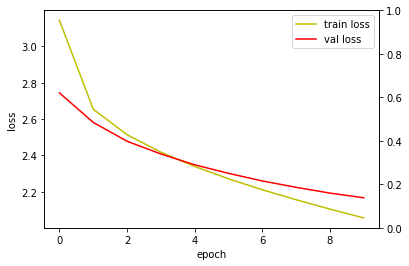

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
plt.show()

* loss와 val_loss 값 차이는 0.11
* overfitting을 억제하기는 했지만 학습 속도가 느림 (약 27분 소요)

#### 2. BATCH_SIZE = 256

In [9]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256

VOCAB_SIZE = tokenizer.num_words + 1   

train_dataset2 = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset2 = train_dataset2.shuffle(BUFFER_SIZE)
train_dataset2 = train_dataset2.batch(BATCH_SIZE, drop_remainder=True)

val_dataset2 = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset2 = val_dataset2.shuffle(BUFFER_SIZE)
val_dataset2 = val_dataset2.batch(BATCH_SIZE, drop_remainder=True)

In [10]:
history = model.fit(train_dataset2, epochs=10, validation_data=val_dataset2)

Epoch 1/10
546/546 [==============================] - 151s 274ms/step - loss: 2.0113 - val_loss: 2.1427
Epoch 2/10
546/546 [==============================] - 150s 274ms/step - loss: 1.9671 - val_loss: 2.1169
Epoch 3/10
546/546 [==============================] - 150s 274ms/step - loss: 1.9204 - val_loss: 2.0930
Epoch 4/10
546/546 [==============================] - 150s 274ms/step - loss: 1.8715 - val_loss: 2.0747
Epoch 5/10
546/546 [==============================] - 150s 275ms/step - loss: 1.8228 - val_loss: 2.0587
Epoch 6/10
546/546 [==============================] - 149s 273ms/step - loss: 1.7744 - val_loss: 2.0391
Epoch 7/10
546/546 [==============================] - 150s 274ms/step - loss: 1.7265 - val_loss: 2.0224
Epoch 8/10
546/546 [==============================] - 149s 272ms/step - loss: 1.6799 - val_loss: 2.0109
Epoch 9/10
546/546 [==============================] - 150s 274ms/step - loss: 1.6343 - val_loss: 1.9994
Epoch 10/10
546/546 [==============================] - 150s 274m

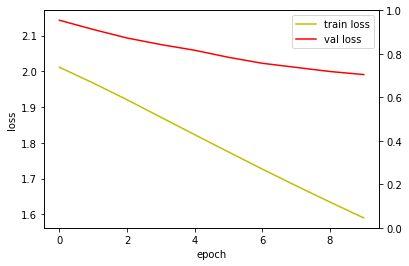

In [11]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
plt.show()

기존 하이퍼파라미터와 동일한데 왜 overfitting이 발생했지? val_loss값이 2정도로 loss값이랑 0.4 차이남. 이정도면 큰 값은 아니지만 이 batch_size를 사용할거면 다른 정규화 방식을 사용해봐야 할 것 같음. dropout or weight decay

#### 3. BATCH_SIZE = 128

In [12]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 128

VOCAB_SIZE = tokenizer.num_words + 1   

train_dataset3 = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset3 = train_dataset3.shuffle(BUFFER_SIZE)
train_dataset3 = train_dataset3.batch(BATCH_SIZE, drop_remainder=True)

val_dataset3 = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset3 = val_dataset3.shuffle(BUFFER_SIZE)
val_dataset3 = val_dataset3.batch(BATCH_SIZE, drop_remainder=True)

In [13]:
history = model.fit(train_dataset3, epochs=10, validation_data=val_dataset3)

Epoch 1/10
1092/1092 [==============================] - 158s 143ms/step - loss: 1.5538 - val_loss: 1.9912
Epoch 2/10
1092/1092 [==============================] - 156s 143ms/step - loss: 1.5199 - val_loss: 1.9892
Epoch 3/10
1092/1092 [==============================] - 156s 143ms/step - loss: 1.4764 - val_loss: 1.9880
Epoch 4/10
1092/1092 [==============================] - 157s 143ms/step - loss: 1.3819 - val_loss: 1.9878
Epoch 6/10
1092/1092 [==============================] - 157s 143ms/step - loss: 1.3356 - val_loss: 1.9950
Epoch 7/10
1092/1092 [==============================] - 155s 142ms/step - loss: 1.2948 - val_loss: 1.9985
Epoch 8/10
1092/1092 [==============================] - 156s 143ms/step - loss: 1.2495 - val_loss: 2.0061
Epoch 9/10
1092/1092 [==============================] - 156s 143ms/step - loss: 1.2083 - val_loss: 2.0128
Epoch 10/10
1092/1092 [==============================] - 155s 142ms/step - loss: 1.1693 - val_loss: 2.0192


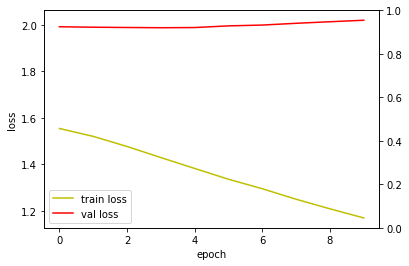

In [14]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
plt.show()

batch_size가 너무 작을 경우 overfitting 발생